In [1]:
!pip -q install timm albumentations opencv-python-headless scikit-learn PyWavelets tqdm


In [2]:
import os, cv2, math, random
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import pywt
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt


In [3]:
ZIP_PATH = "/content/archive.zip"
OUT_DIR  = "/content/dataset"

!rm -rf "{OUT_DIR}"
!mkdir -p "{OUT_DIR}"
!unzip -q "{ZIP_PATH}" -d "{OUT_DIR}"
print("✅ Extracted to:", OUT_DIR)

!find /content/dataset -maxdepth 3 -type f | head -n 10


✅ Extracted to: /content/dataset
/content/dataset/idrid_labels.csv
/content/dataset/Imagenes/Imagenes/IDRiD_348.jpg
/content/dataset/Imagenes/Imagenes/IDRiD_197.jpg
/content/dataset/Imagenes/Imagenes/IDRiD_274.jpg
/content/dataset/Imagenes/Imagenes/IDRiD_031.jpg
/content/dataset/Imagenes/Imagenes/IDRiD_073.jpg
/content/dataset/Imagenes/Imagenes/IDRiD_102.jpg
/content/dataset/Imagenes/Imagenes/IDRiD_322.jpg
/content/dataset/Imagenes/Imagenes/IDRiD_044.jpg
/content/dataset/Imagenes/Imagenes/IDRiD_255.jpg


In [4]:
root = Path(OUT_DIR)


img_files = sorted(list(root.rglob("*.jpg")) + list(root.rglob("*.png")) + list(root.rglob("*.jpeg")))
assert len(img_files) > 0, "❌ No images found in dataset."


clean_imgs = []
for p in img_files:
    if p.stem.endswith("test"):
        continue
    clean_imgs.append(p)
img_files = clean_imgs if len(clean_imgs) > 0 else img_files

df = pd.DataFrame({
    "id_code": [p.stem for p in img_files],
    "img_path": [str(p) for p in img_files]
})


csvs = list(root.rglob("*.csv"))

if len(csvs) > 0:
    csv_path = csvs[0]
    lab = pd.read_csv(csv_path)
    lab.columns = [c.strip() for c in lab.columns]
    if "id_code" in lab.columns and "diagnosis" in lab.columns:
        lab = lab[["id_code","diagnosis"]].copy()
        lab["diagnosis"] = lab["diagnosis"].astype(int)
        df = df.merge(lab, on="id_code", how="inner")
        print("✅ Using REAL labels from:", csv_path)
    else:
        print("⚠️ CSV found but missing id_code/diagnosis. Using demo labels.")
        df["diagnosis"] = np.random.randint(0,5,len(df))
else:
    print("⚠️ No label CSV found in dataset. Creating DEMO labels so training+metrics run.")
    df["diagnosis"] = np.random.randint(0,5,len(df))

print("✅ Final df:", df.shape)
print(df.head())
print("Class counts:\n", df["diagnosis"].value_counts().sort_index())


✅ Using REAL labels from: /content/dataset/idrid_labels.csv
✅ Final df: (375, 3)
     id_code                                          img_path  diagnosis
0  IDRiD_001  /content/dataset/Imagenes/Imagenes/IDRiD_001.jpg          3
1  IDRiD_002  /content/dataset/Imagenes/Imagenes/IDRiD_002.jpg          3
2  IDRiD_003  /content/dataset/Imagenes/Imagenes/IDRiD_003.jpg          2
3  IDRiD_004  /content/dataset/Imagenes/Imagenes/IDRiD_004.jpg          3
4  IDRiD_005  /content/dataset/Imagenes/Imagenes/IDRiD_005.jpg          4
Class counts:
 diagnosis
0    114
1     17
2    125
3     64
4     55
Name: count, dtype: int64


In [5]:
def lab_l_and_dwt(img_bgr, out_size=224):
    img_bgr = cv2.resize(img_bgr, (out_size, out_size), interpolation=cv2.INTER_AREA)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    L = lab[:, :, 0].astype(np.float32) / 255.0

    LL, (LH, HL, HH) = pywt.dwt2(L, "haar")
    detail = (np.abs(LH) + np.abs(HL) + np.abs(HH)) / 3.0

    LL_up = cv2.resize(LL, (out_size, out_size), interpolation=cv2.INTER_CUBIC)
    D_up  = cv2.resize(detail, (out_size, out_size), interpolation=cv2.INTER_CUBIC)

    LL_up = np.clip(LL_up, 0, 1).astype(np.float32)
    D_up  = np.clip(D_up,  0, 1).astype(np.float32)

    x = np.stack([L, LL_up, D_up], axis=-1)
    return x


In [6]:
IMG_SIZE = 224

train_tfms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.10, rotate_limit=10, p=0.5),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

class DRDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["img_path"]
        y = int(row["diagnosis"])

        img_bgr = cv2.imread(path)
        if img_bgr is None:
            raise FileNotFoundError(f"❌ Failed read: {path}")

        x = lab_l_and_dwt(img_bgr, out_size=IMG_SIZE)

        if self.tfms:
            x = self.tfms(image=x)["image"]

        return x, torch.tensor(y, dtype=torch.long)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["diagnosis"])
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

BATCH_SIZE = 8
train_loader = DataLoader(DRDataset(train_df, train_tfms), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(DRDataset(val_df,   val_tfms),   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

xb, yb = next(iter(train_loader))
print("✅ Batch:", xb.shape, yb.shape)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


✅ Batch: torch.Size([8, 3, 224, 224]) torch.Size([8])


In [7]:
NUM_CLASSES = 5

class CNNTransformerFusion(nn.Module):
    def __init__(self, num_classes=5, d_model=512, n_tokens=8, n_heads=8, n_layers=2, dropout=0.1):
        super().__init__()
        self.num_classes = num_classes
        self.n_tokens = n_tokens
        self.d_model = d_model

        self.eff = timm.create_model("efficientnet_b4", pretrained=True, num_classes=0, global_pool="avg")
        self.cnx = timm.create_model("convnext_tiny", pretrained=True, num_classes=0, global_pool="avg")

        f1 = self.eff.num_features
        f2 = self.cnx.num_features

        self.fuse = nn.Sequential(
            nn.Linear(f1 + f2, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
        )

        self.to_tokens = nn.Linear(d_model, n_tokens * d_model)
        self.pos = nn.Parameter(torch.zeros(1, n_tokens, d_model))

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=4*d_model,
            dropout=dropout, activation="gelu", batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.cls_head = nn.Linear(d_model, num_classes)       # for focal loss + AUC
        self.ord_head = nn.Linear(d_model, num_classes - 1)   # ordinal logits

    def forward(self, x):
        f_eff = self.eff(x)
        f_cnx = self.cnx(x)
        f = torch.cat([f_eff, f_cnx], dim=1)

        z = self.fuse(f)
        tok = self.to_tokens(z).view(x.size(0), self.n_tokens, self.d_model) + self.pos
        tok = self.encoder(tok)
        rep = tok.mean(dim=1)

        return self.cls_head(rep), self.ord_head(rep)


In [8]:
def make_ordinal_targets(y, num_classes=5):
    B = y.size(0)
    t = torch.zeros((B, num_classes-1), device=y.device)
    for j in range(num_classes-1):
        t[:, j] = (y > j).float()
    return t

class FocalLossCE(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, reduction="none", weight=self.weight)
        pt = torch.exp(-ce)
        return (((1-pt)**self.gamma) * ce).mean()

bce_logits = nn.BCEWithLogitsLoss()


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNTransformerFusion(num_classes=NUM_CLASSES).to(device)


counts = train_df["diagnosis"].value_counts().sort_index()
freq = counts.values.astype(np.float32)
inv = 1.0/(freq+1e-6)
w = inv/inv.sum()*len(inv)
class_w = torch.tensor(w, dtype=torch.float32).to(device)

focal = FocalLossCE(gamma=2.0, weight=class_w)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

@torch.no_grad()
def ordinal_pred(ord_logits):
    return (torch.sigmoid(ord_logits) > 0.5).sum(dim=1).long()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys, ps = [], []
    prob_list = []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        cls_logits, ord_logits = model(x)
        pred = ordinal_pred(ord_logits)

        ys.append(y.cpu().numpy())
        ps.append(pred.cpu().numpy())
        prob_list.append(torch.softmax(cls_logits, dim=1).cpu().numpy())

    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    probs  = np.concatenate(prob_list)

    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    f1  = f1_score(y_true, y_pred, average="macro")

    try:
        auc = roc_auc_score(y_true, probs, multi_class="ovr")
    except Exception:
        auc = float("nan")

    return qwk, f1, auc

EPOCHS = 2
LAMBDA_ORD = 1.0

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        x, y = x.to(device), y.to(device)

        opt.zero_grad(set_to_none=True)
        cls_logits, ord_logits = model(x)

        loss_f = focal(cls_logits, y)
        t_ord = make_ordinal_targets(y, NUM_CLASSES)
        loss_o = bce_logits(ord_logits, t_ord)

        loss = loss_f + LAMBDA_ORD * loss_o
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        running += loss.item()

    qwk, f1, auc = evaluate(model, val_loader)
    print(f"\n✅ Epoch {epoch} | train_loss={running/len(train_loader):.4f} | QWK={qwk:.4f} | F1={f1:.4f} | AUC={auc:.4f}")

torch.save(model.state_dict(), "/content/last_dr_model.pth")
print("✅ Saved: /content/last_dr_model.pth")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
Epoch 1/2: 100%|██████████| 38/38 [07:39<00:00, 12.09s/it]



✅ Epoch 1 | train_loss=1.3065 | QWK=0.0000 | F1=0.1000 | AUC=0.5136


Epoch 2/2: 100%|██████████| 38/38 [07:26<00:00, 11.75s/it]



✅ Epoch 2 | train_loss=1.1878 | QWK=0.2277 | F1=0.1930 | AUC=0.6784
✅ Saved: /content/last_dr_model.pth


In [10]:
vit_model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=NUM_CLASSES).to(device).eval()
swin_model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=NUM_CLASSES).to(device).eval()

rgb_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

@torch.no_grad()
def vit_swin_predict(img_path):
    bgr = cv2.imread(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    x = rgb_tfms(image=rgb)["image"].unsqueeze(0).to(device)

    vit_probs  = torch.softmax(vit_model(x), dim=1).cpu().numpy()[0]
    swin_probs = torch.softmax(swin_model(x), dim=1).cpu().numpy()[0]

    return int(np.argmax(vit_probs)), float(np.max(vit_probs)), int(np.argmax(swin_probs)), float(np.max(swin_probs))


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]


==== DR PREDICTION RESULT ====
Image: /content/dataset/Imagenes/Imagenes/IDRiD_321.jpg
DR affected: YES
Predicted Grade: 2 - Moderate

Confidence per class:
  0 (No DR): 8.94%
  1 (Mild): 6.68%
  2 (Moderate): 28.52%
  3 (Severe): 17.77%
  4 (Proliferative DR): 38.09%

ViT baseline -> Grade: 4 (Proliferative DR) | Conf: 0.371
Swin baseline -> Grade: 4 (Proliferative DR) | Conf: 0.239


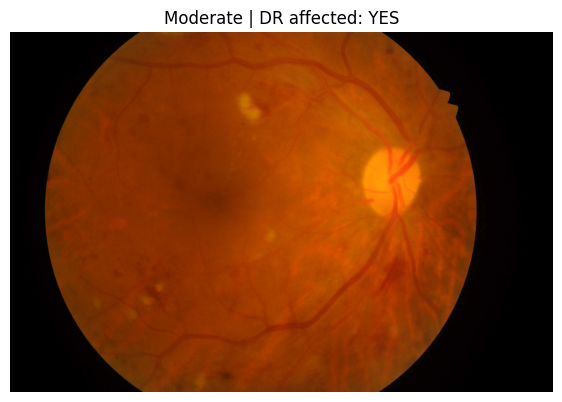

In [11]:
GRADE_NAME = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

@torch.no_grad()
def predict_one(img_path):
    model.eval()
    bgr = cv2.imread(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


    x = lab_l_and_dwt(bgr, IMG_SIZE)
    x = val_tfms(image=x)["image"].unsqueeze(0).to(device)

    cls_logits, ord_logits = model(x)
    pred_grade = int(ordinal_pred(ord_logits).item())
    probs = torch.softmax(cls_logits, dim=1).cpu().numpy()[0]
    dr_yes = "YES" if pred_grade>=1 else "NO"

    print("\n==== DR PREDICTION RESULT ====")
    print("Image:", img_path)
    print("DR affected:", dr_yes)
    print(f"Predicted Grade: {pred_grade} - {GRADE_NAME[pred_grade]}\n")
    print("Confidence per class:")
    for k in range(5):
        print(f"  {k} ({GRADE_NAME[k]}): {probs[k]*100:.2f}%")


    v_g, v_c, s_g, s_c = vit_swin_predict(img_path)
    print(f"\nViT baseline -> Grade: {v_g} ({GRADE_NAME[v_g]}) | Conf: {v_c:.3f}")
    print(f"Swin baseline -> Grade: {s_g} ({GRADE_NAME[s_g]}) | Conf: {s_c:.3f}")

    plt.figure(figsize=(7,5))
    plt.imshow(rgb); plt.axis("off")
    plt.title(f"{GRADE_NAME[pred_grade]} | DR affected: {dr_yes}")
    plt.show()


predict_one(val_df["img_path"].iloc[0])


In [12]:
failed = 0
used = 0
affected = 0
unaffected = 0

for p in tqdm(df["img_path"].tolist(), desc="Counting DR affected/unaffected"):
    bgr = cv2.imread(p)
    if bgr is None:
        failed += 1
        continue
    used += 1

    x = lab_l_and_dwt(bgr, IMG_SIZE)
    x = val_tfms(image=x)["image"].unsqueeze(0).to(device)
    with torch.no_grad():
        cls_logits, ord_logits = model(x)
        g = int(ordinal_pred(ord_logits).item())

    if g >= 1: affected += 1
    else: unaffected += 1

print("\n===== DATASET DR COUNT SUMMARY =====")
print("Total images in df:", len(df))
print("Predicted (used):", used)
print("Failed reads:", failed)
print("Affected (DR YES):", affected)
print("Unaffected (No DR):", unaffected)
print("Affected %:", (affected/used*100) if used>0 else 0)


Counting DR affected/unaffected: 100%|██████████| 375/375 [03:17<00:00,  1.90it/s]


===== DATASET DR COUNT SUMMARY =====
Total images in df: 375
Predicted (used): 375
Failed reads: 0
Affected (DR YES): 325
Unaffected (No DR): 50
Affected %: 86.66666666666667


In [13]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_last_conv_layer(model_part):
    last_conv = None
    for m in model_part.modules():
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
    if last_conv is None:
        raise RuntimeError("❌ No Conv2d layer found for Grad-CAM.")
    return last_conv

def gradcam_effnet(model, img_path):
    model.eval()

    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise FileNotFoundError(f"❌ Cannot read: {img_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


    x = lab_l_and_dwt(img_bgr, out_size=IMG_SIZE)
    x_t = val_tfms(image=x)["image"].unsqueeze(0).to(device)

    target_layer = find_last_conv_layer(model.eff)

    activations = None
    gradients = None

    def fwd_hook(module, inp, out):
        nonlocal activations
        activations = out

    def bwd_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)

    cls_logits, ord_logits = model(x_t)


    pred_grade = int((torch.sigmoid(ord_logits) > 0.5).sum(dim=1).item())


    score = cls_logits[0, pred_grade]
    model.zero_grad(set_to_none=True)
    score.backward()

    h1.remove(); h2.remove()

    weights = gradients.mean(dim=(2,3), keepdim=True)
    cam = (weights * activations).sum(dim=1)
    cam = torch.relu(cam)[0].detach().cpu().numpy()

    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)

    cam_resized = cv2.resize(cam, (img_rgb.shape[1], img_rgb.shape[0]))

    heatmap = (cam_resized * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img_rgb, 0.65, heatmap_rgb, 0.35, 0)

    probs = torch.softmax(cls_logits, dim=1).detach().cpu().numpy()[0]
    conf = float(probs[pred_grade])

    return img_rgb, cam_resized, heatmap_rgb, overlay, pred_grade, conf, probs


In [14]:
GRADE_NAME = {0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

def show_gradcam_comparison(img_path, save_path=None):
    img_rgb, cam, heatmap_rgb, overlay, pred_grade, conf, probs = gradcam_effnet(model, img_path)

    dr_yes = "YES" if pred_grade >= 1 else "NO"

    plt.figure(figsize=(18,5))

    plt.subplot(1,3,1)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1,3,2)
    plt.imshow(heatmap_rgb)
    plt.axis("off")
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Overlay | Pred: {pred_grade} ({GRADE_NAME[pred_grade]}) | DR: {dr_yes} | Conf: {conf:.3f}")

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        print("✅ Saved:", save_path)

    plt.show()

    print("Class probabilities:", np.round(probs, 3))


✅ Saved: /content/gradcam_compare/compare_1.png


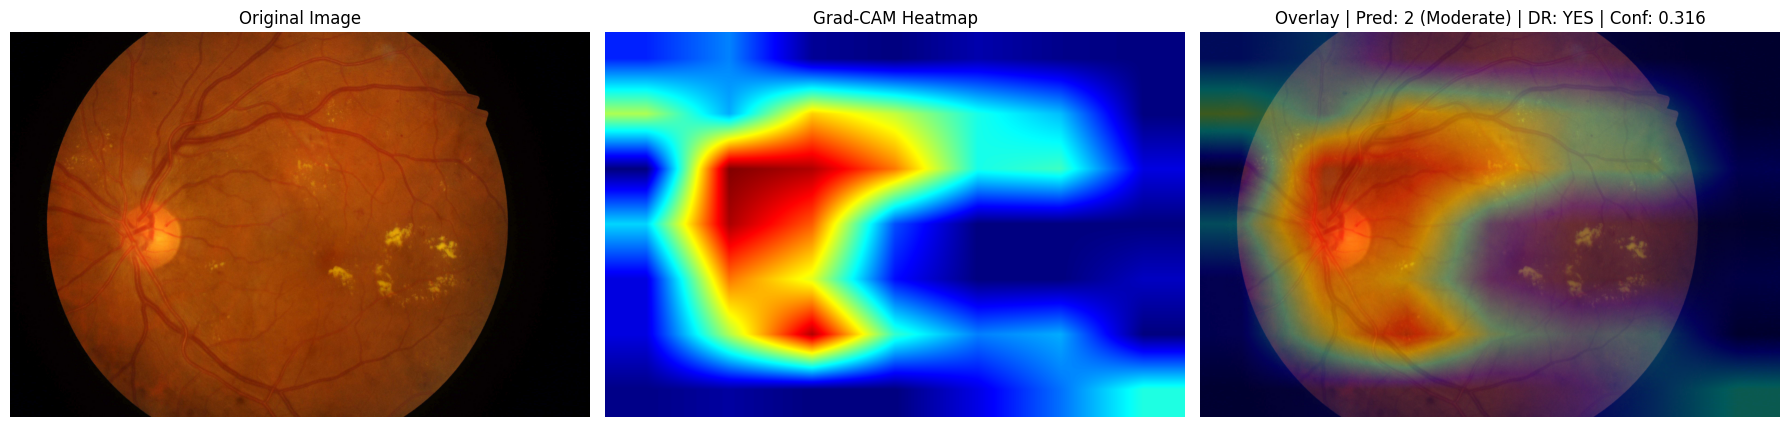

Class probabilities: [0.207 0.063 0.316 0.131 0.283]
✅ Saved: /content/gradcam_compare/compare_2.png


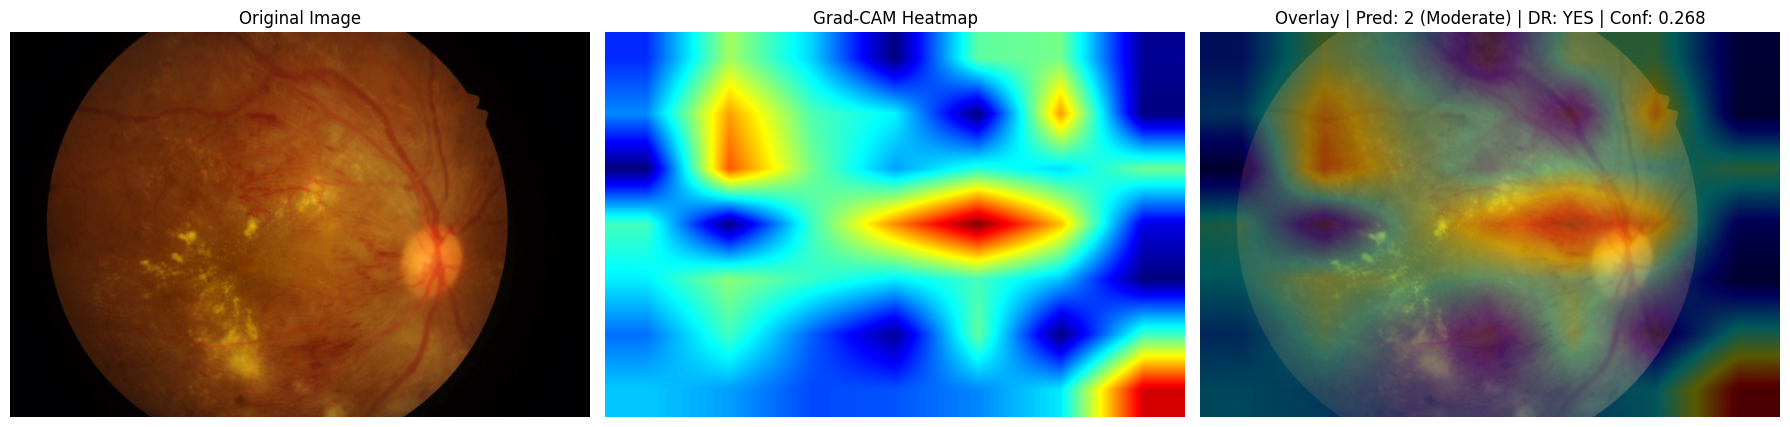

Class probabilities: [0.082 0.065 0.268 0.182 0.402]
✅ Saved: /content/gradcam_compare/compare_3.png


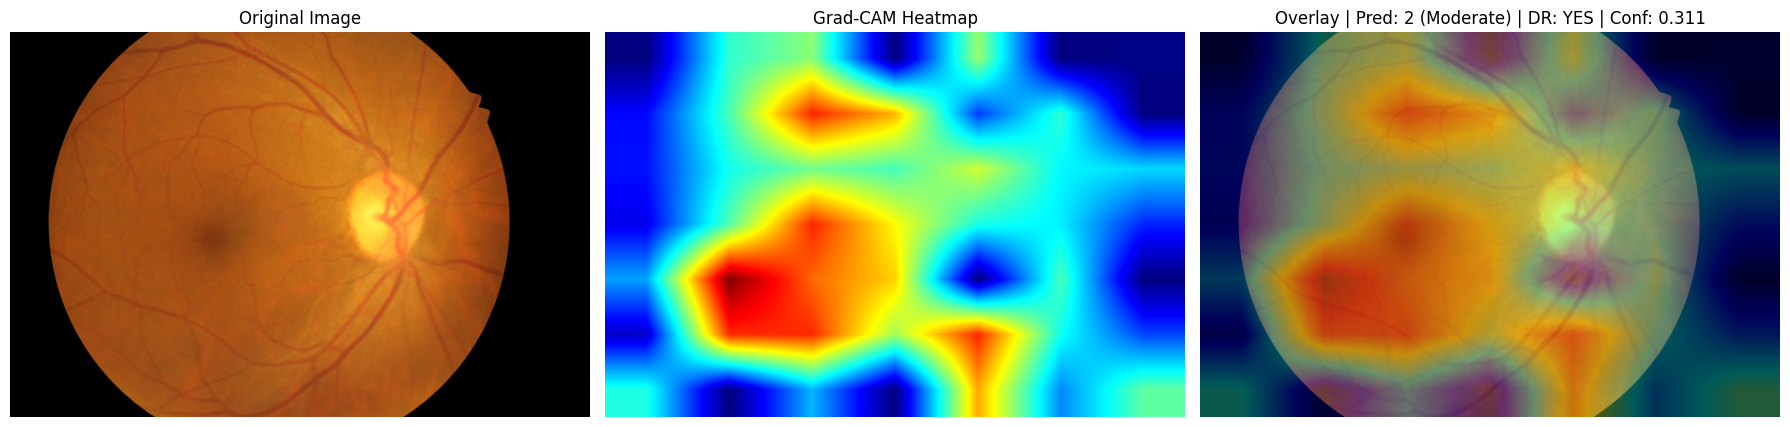

Class probabilities: [0.126 0.069 0.311 0.158 0.336]
✅ Saved: /content/gradcam_compare/compare_4.png


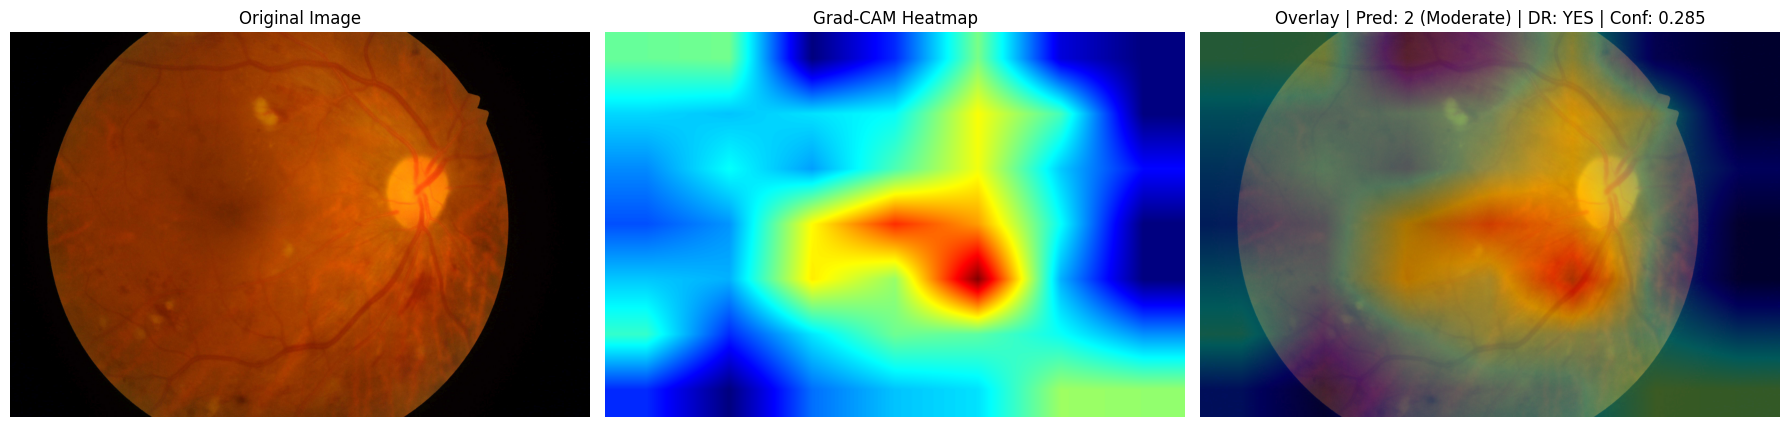

Class probabilities: [0.089 0.067 0.285 0.178 0.381]
✅ Saved: /content/gradcam_compare/compare_5.png


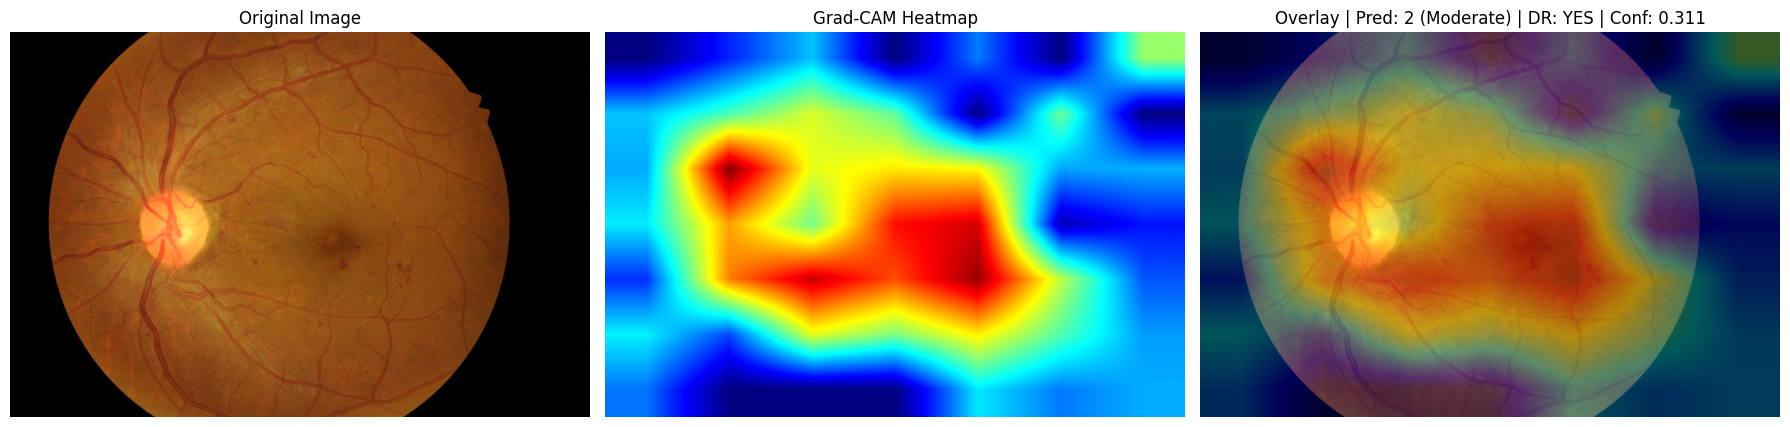

Class probabilities: [0.123 0.068 0.311 0.158 0.34 ]
✅ Saved: /content/gradcam_compare/compare_6.png


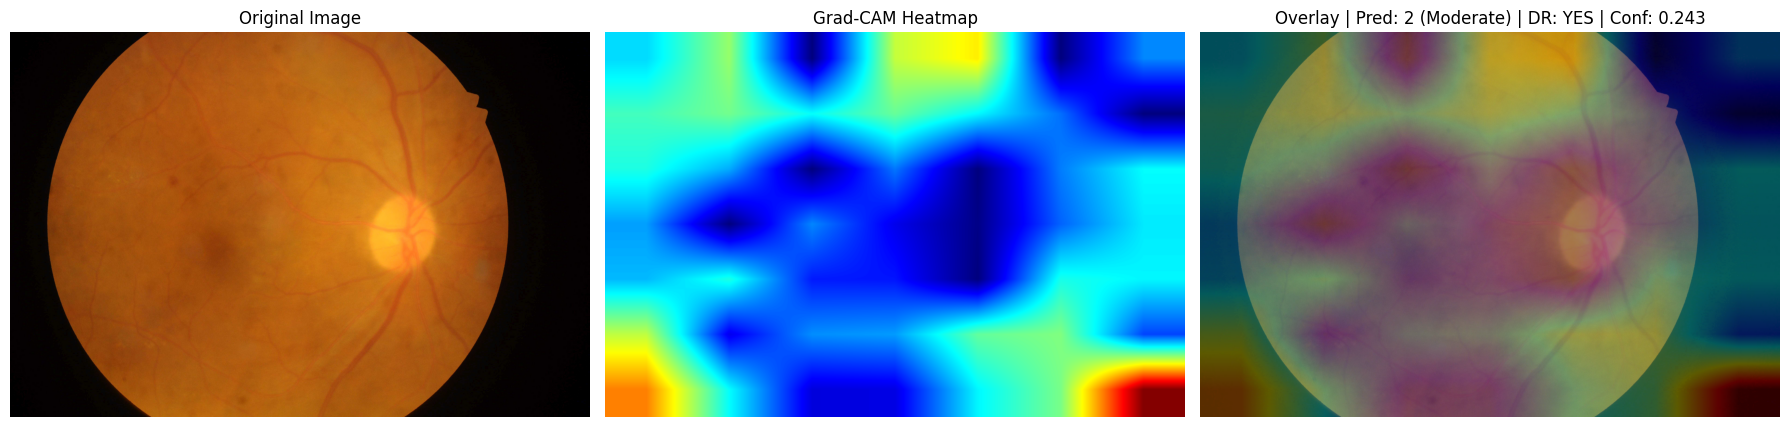

Class probabilities: [0.046 0.066 0.243 0.204 0.441]
✅ Saved: /content/gradcam_compare/compare_7.png


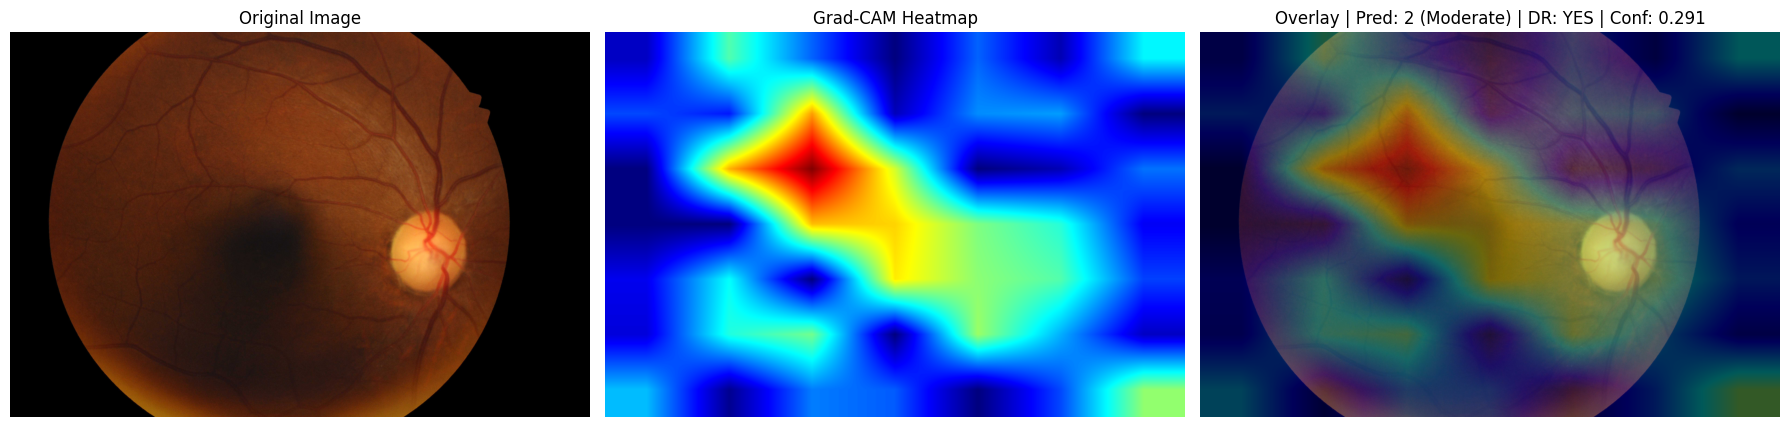

Class probabilities: [0.105 0.066 0.291 0.17  0.368]
✅ Saved: /content/gradcam_compare/compare_8.png


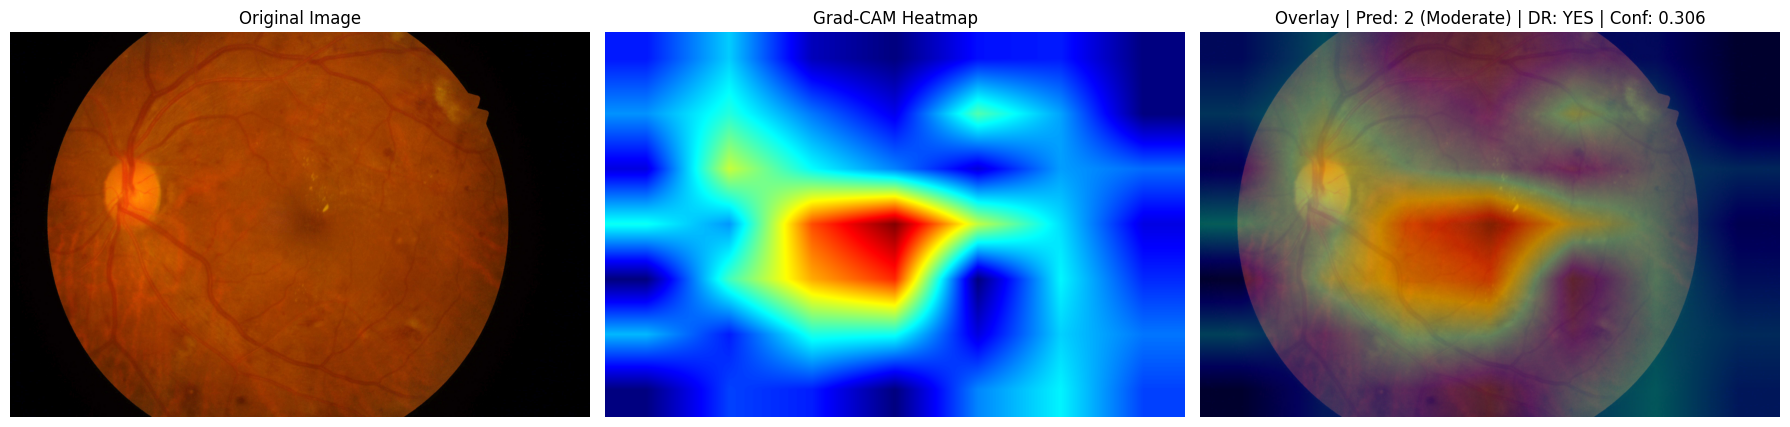

Class probabilities: [0.126 0.067 0.306 0.16  0.341]
✅ Saved: /content/gradcam_compare/compare_9.png


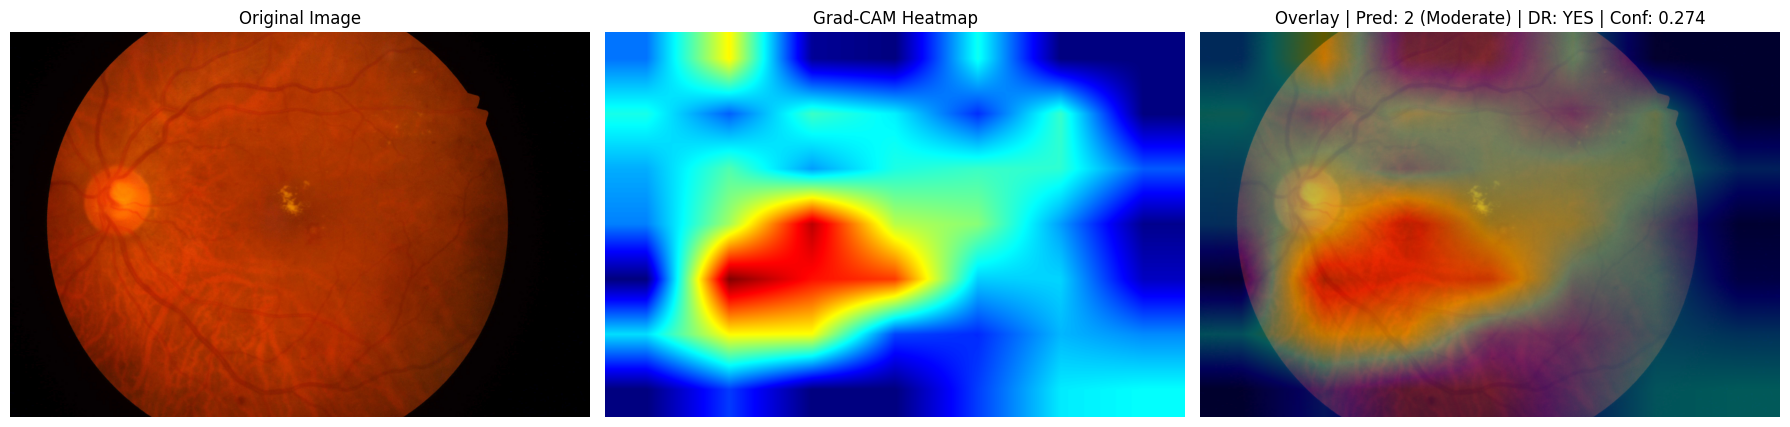

Class probabilities: [0.083 0.067 0.274 0.18  0.396]
✅ Saved: /content/gradcam_compare/compare_10.png


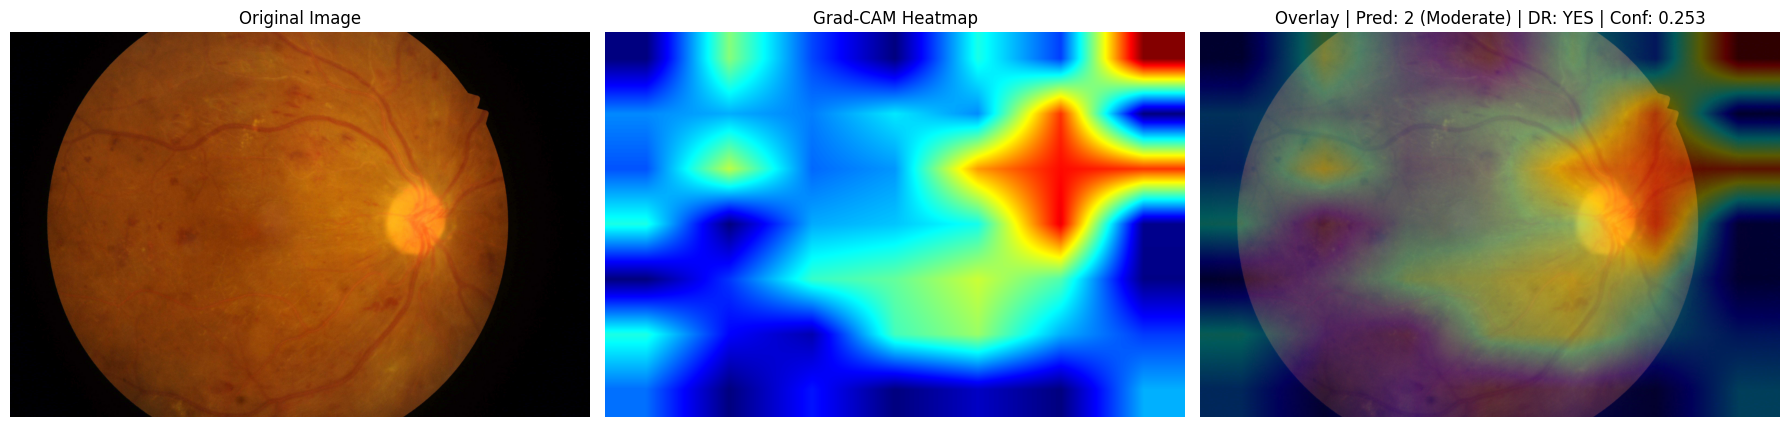

Class probabilities: [0.06  0.065 0.253 0.194 0.428]
✅ All saved in: /content/gradcam_compare


In [15]:
OUT_DIR = "/content/gradcam_compare"
os.makedirs(OUT_DIR, exist_ok=True)

sample_rows = val_df.sample(10, random_state=42).reset_index(drop=True)

for i in range(10):
    p = sample_rows.loc[i, "img_path"]
    save_path = f"{OUT_DIR}/compare_{i+1}.png"
    show_gradcam_comparison(p, save_path=save_path)

print("✅ All saved in:", OUT_DIR)
